In [3]:
from matplotlib.animation import FuncAnimation
from scipy.stats import norm, multivariate_normal

import numpy as np
import matplotlib.pyplot as plt

## 1. Robot kidnapping problem - 1D

In [4]:
N = 100
doors = [30, 50, 80]

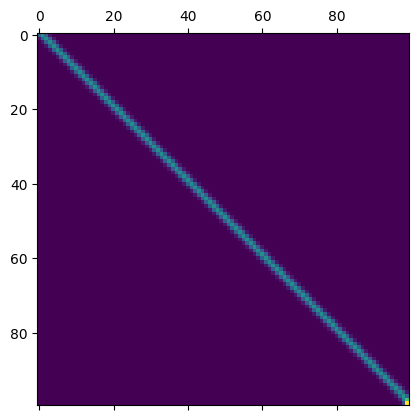

In [5]:
M = np.zeros((N, N))
for i in range(N):
    M[i, :] = norm.pdf(range(N), i+1, 1)

M = M / np.sum(M, axis=1)[:, None]

plt.matshow(M)

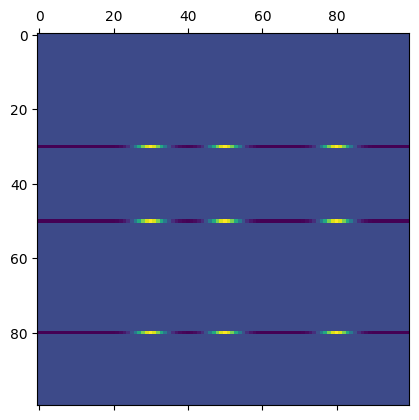

In [6]:
p_z_x = np.zeros((N, N))
for i in range(N):
    if i in doors:
        p_z_x[i, :] = np.sum([norm.pdf(range(N), j, 3) for j in doors], axis=0)
        p_z_x[i, :] = p_z_x[i, :] / np.sum(p_z_x[i, :])
    else:
        p_z_x[i, :] = np.ones(N) / N

plt.matshow(p_z_x)

In [7]:
bel = np.ones(N) / N
bels = [bel]

for i in range(100):
    bel = bel @ M
    bel = p_z_x[i, :] * bel
    bel = bel / np.sum(bel)
    bels.append(bel)

MovieWriter imagemagick unavailable; using Pillow instead.


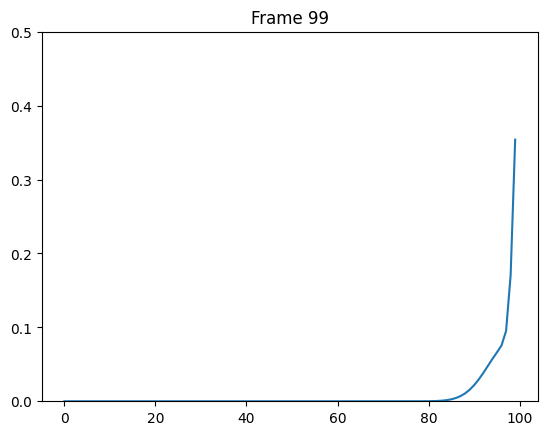

In [8]:
def plot_bel(frame, bels, N, ax):
    ax.clear()
    ax.plot(bels[frame])
    ax.set_ylim(0, 0.5)
    ax.set_title(f'Frame {frame}')


fig, ax = plt.subplots()
ani = FuncAnimation(fig, plot_bel, frames=range(100), fargs=(bels, N, ax))

ani.save('robot_kidnapping_1D.gif', writer='imagemagick', fps=10)
plt.show()

## 2. Robot kidnapping problem - 2D

In [9]:
N, M = 100, 100
moves = [(1, 0), (0, 1), (-1, 0), (0, -1)]
manholes = [(30, 50), (50, 80), (80, 30)]
us = [0]*10 + [1]*30 + [0]*20 + [1]*30 + [0]*30 + [3]*50 + [2]*30 + [1]*20

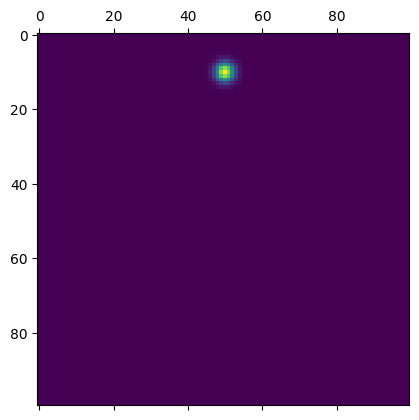

In [10]:
def state_transition(x, y, N, M, u):
    dx, dy = moves[u]
    nx = x + dx
    ny = y + dy
    result = multivariate_normal.pdf(np.dstack(np.mgrid[0:N, 0:M]), mean=[nx, ny], cov=3*np.eye(2))
    return result / np.sum(result)


test = state_transition(9, 50, N, M, 0)
plt.matshow(test)

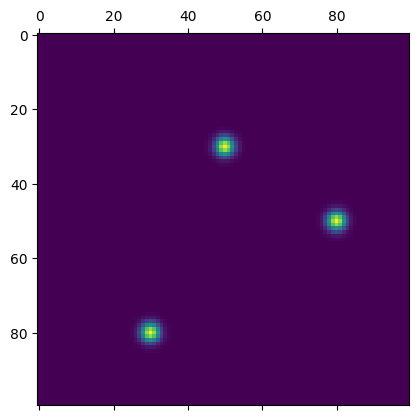

In [11]:
def measurement_model(x, y, N, M):
    result = np.zeros((N, M))
    if (x, y) not in manholes:
        return np.ones((N, M)) / (N*M)
    else:
        for m_x, m_y in manholes:
            result += multivariate_normal.pdf(np.dstack(np.mgrid[0:N, 0:M]), mean=[m_x, m_y], cov=3*np.eye(2))
        return result / np.sum(result)

test = measurement_model(30, 50, N, M)
plt.matshow(test)

In [12]:
from tqdm.auto import tqdm

bel = np.ones((N, M)) / (N*M)
bels = [bel]
robot = (20, 20)

for u in tqdm(us):
    bel_new = np.zeros((N, M))
    for x in range(N):
        for y in range(M):
            bel_new += bel[x, y] * state_transition(x, y, N, M, u)
    robot = (robot[0] + moves[u][0], robot[1] + moves[u][1])
    bel_new = bel_new * measurement_model(robot[0], robot[1], N, M)
    bel = bel_new / np.sum(bel_new)
    bels.append(bel)

  0%|          | 0/220 [00:00<?, ?it/s]

MovieWriter imagemagick unavailable; using Pillow instead.


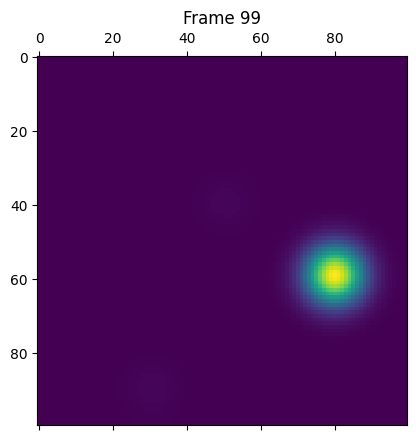

In [13]:
def plot_bel(frame, bels, N, ax):
    ax.clear()
    ax.matshow(bels[frame])
    ax.set_title(f'Frame {frame}')


fig, ax = plt.subplots()
ani = FuncAnimation(fig, plot_bel, frames=range(100), fargs=(bels, N, ax))

ani.save('robot_kidnapping_2D.gif', writer='imagemagick', fps=10)
plt.show()